In [15]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from scipy.stats import pearsonr
from nilearn import datasets
from nilearn import plotting
from nilearn import surface
from nilearn.datasets import fetch_surf_fsaverage
import seaborn as sns

Reading labels from parcellation...
   read 101 labels from C:\Users\sorenza_bastiaens\Documents\Project_2\freesurfer_subjects\fsaverage_small\label\lh.Schaefer2018_200Parcels_17Networks_order.annot
   read 101 labels from C:\Users\sorenza_bastiaens\Documents\Project_2\freesurfer_subjects\fsaverage_small\label\rh.Schaefer2018_200Parcels_17Networks_order.annot


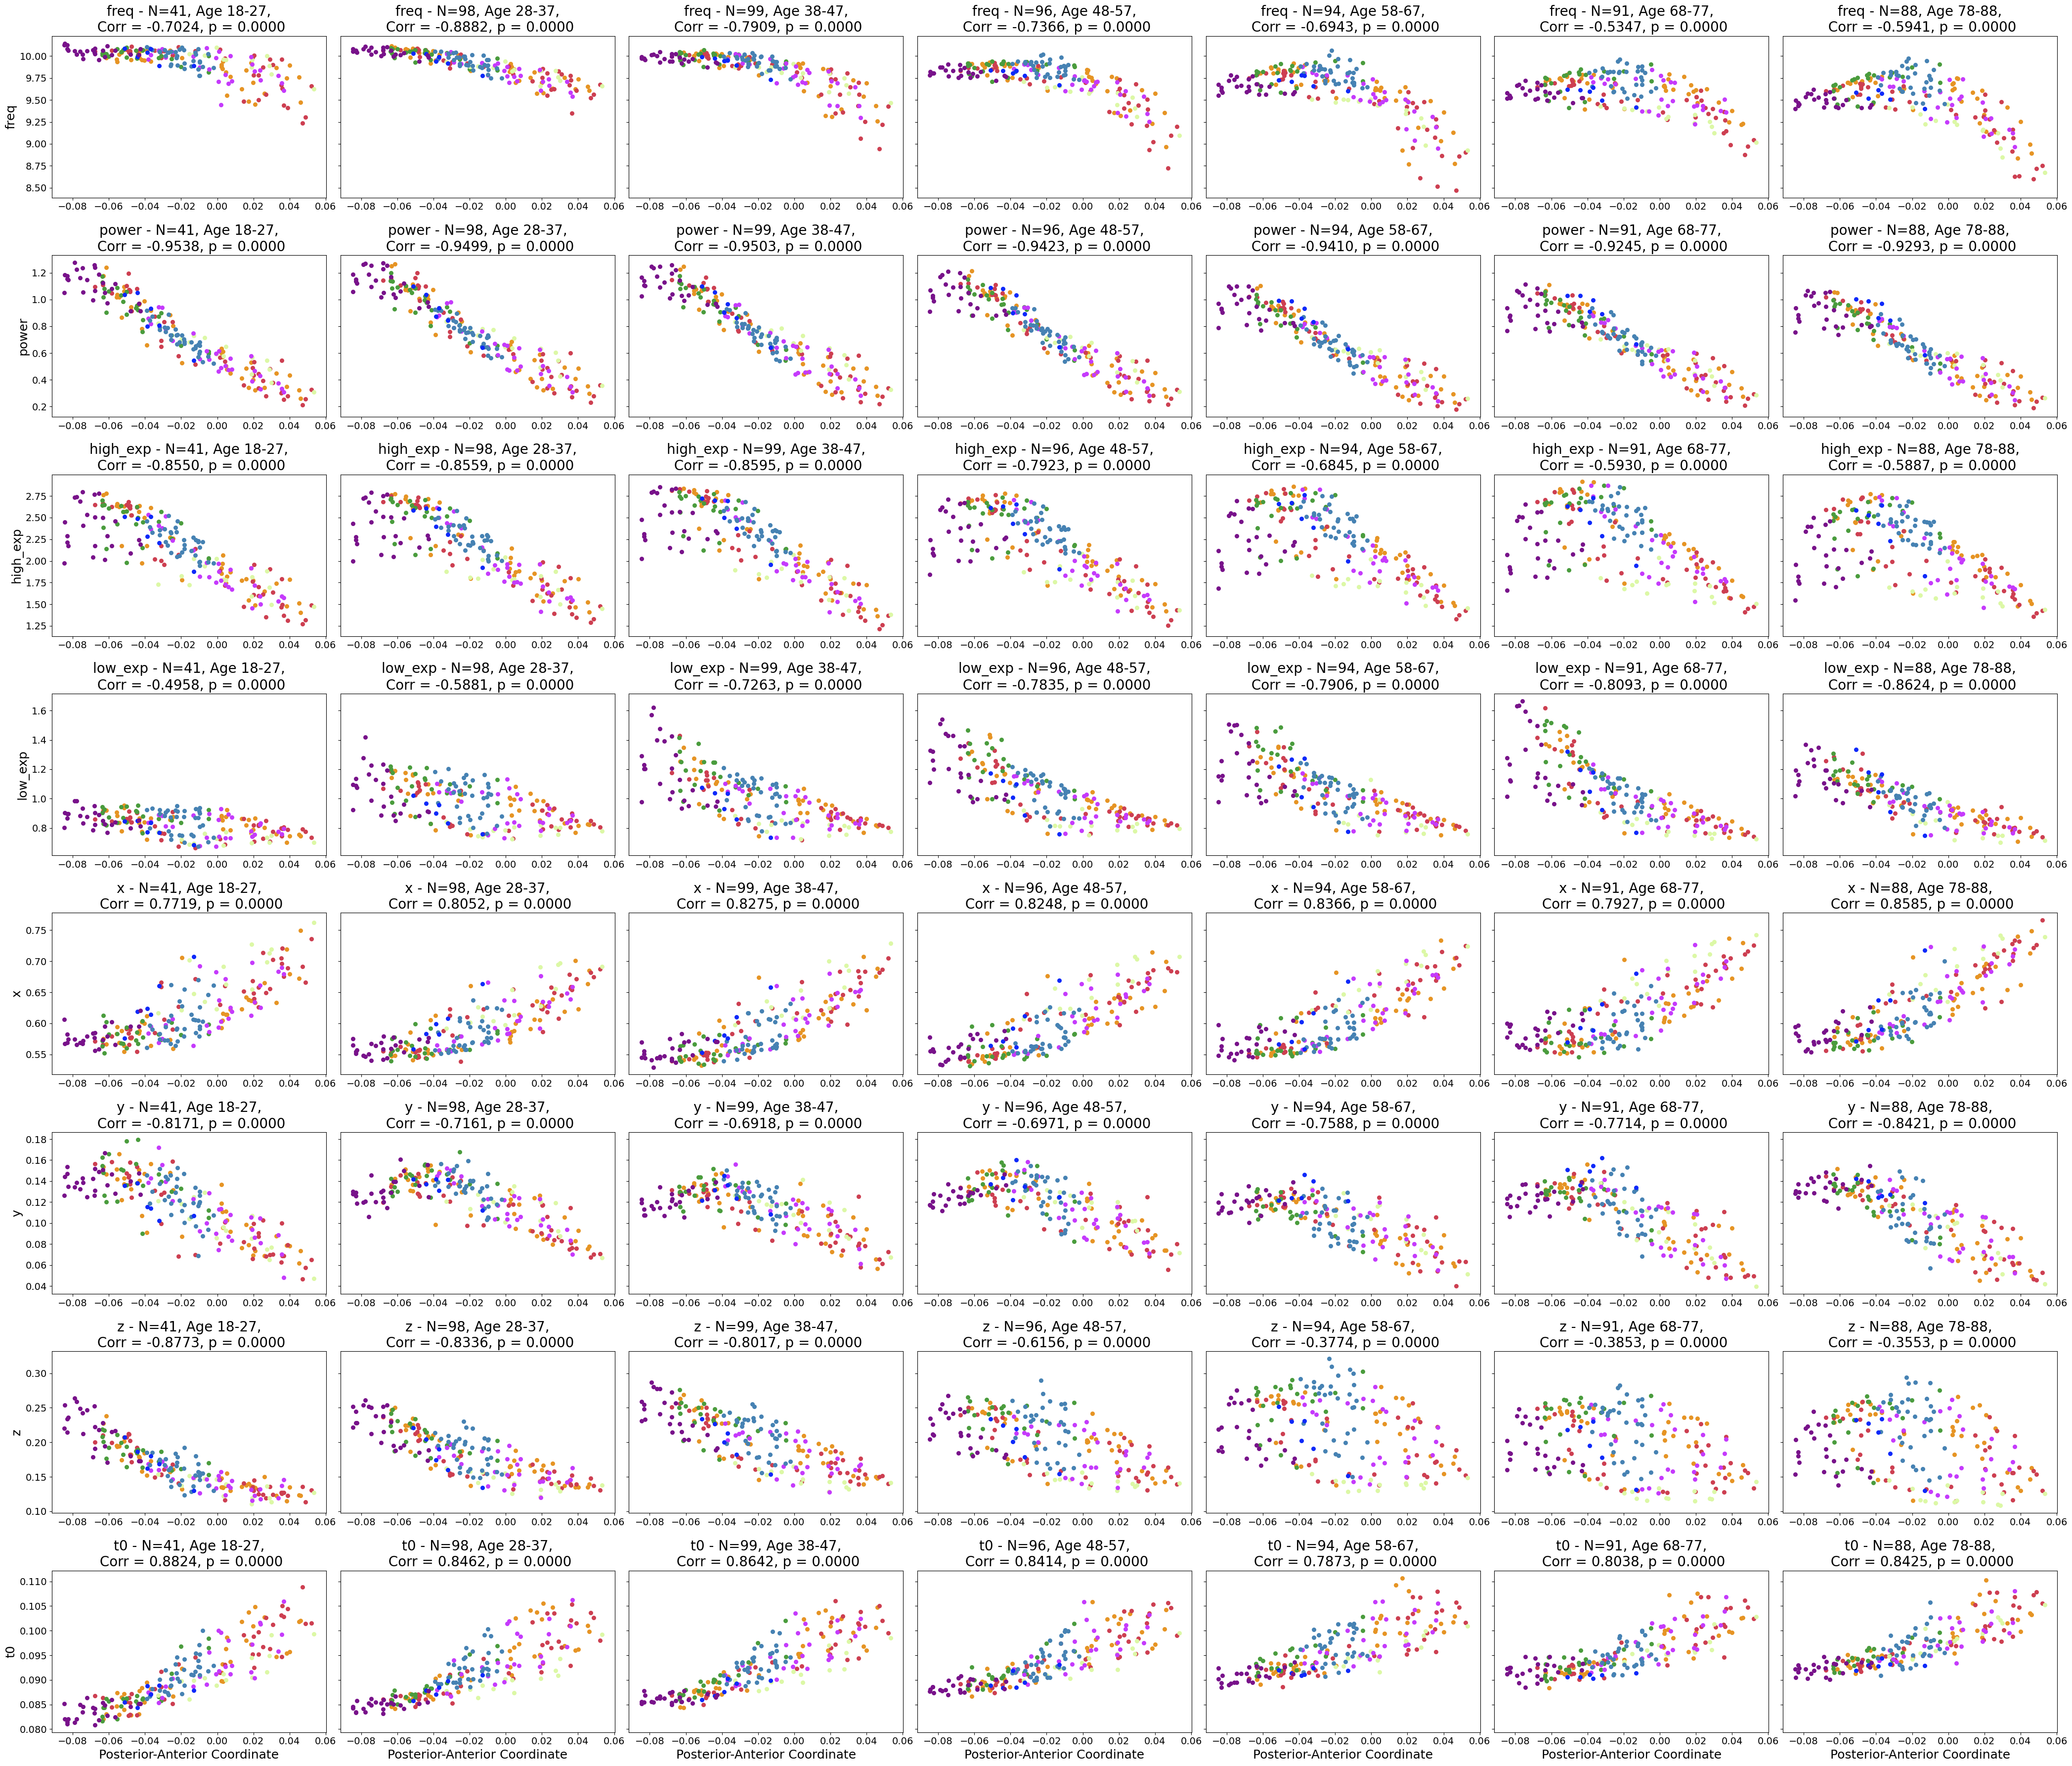

In [ ]:
subjects_dir = '/path_to_freesurfer/freesurfer_subjects'
subject = 'fsaverage_small'
os.environ['SUBJECTS_DIR'] = subjects_dir
src = mne.read_source_spaces(subjects_dir + '/fsaverage_small/bem/fsaverage_small-oct6-src.fif', verbose=False)
# For schaefer
labels = mne.read_labels_from_annot(
    subject= 'fsaverage_small', parc="Schaefer2018_200Parcels_17Networks_order", subjects_dir=subjects_dir
)

# Get label names
label_names = [label.name for label in labels[:-2]] 

src = mne.read_source_spaces(subjects_dir + '/fsaverage_small/bem/fsaverage_small-oct6-src.fif', verbose=False)
y_avg_coord = np.zeros(len(labels)-2)

for i in range(0,len(labels)-2):
    if i < 100:
        lh_coordinates = src[0]['rr'][labels[i].vertices]
        y_avg_coord[i] = lh_coordinates[:, 1].mean()
    else:
        rh_coordinates = src[1]['rr'][labels[i].vertices]
        y_avg_coord[i] = rh_coordinates[:, 1].mean()


df = pd.read_csv('/data/combined_data_final.csv')

plt.rcParams.update({'font.size': 16})  # Global font size

# Define parameter list
parameters = ['freq', 'power', 'high_exp','low_exp','x', 'y', 'z', 't0']
# Group by age_group
age_groups = df.groupby('age_group')
n_params = len(parameters)
n_groups = len(age_groups)

# Create subplots: rows = parameters, columns = age groups
fig, axs = plt.subplots(n_params, n_groups, figsize=(6 * n_groups, 4.5 * n_params), sharey = 'row')

# Color index mapping
network_color_indices = {
    'Cont': 1,
    'Default': 29,
    'DorsAttn': 43,
    'Limbic': 54,
    'SalVentAttn': 60,
    'SomMo': 71,
    'TempPar': 185,
    'Vis': 90
}

for param_idx, param in enumerate(parameters):
    for group_idx, (age_group, data_group) in enumerate(age_groups):
        num_subjects = data_group['participant_id'].nunique()
        new_mat = data_group[param].values.reshape(num_subjects, 200)
        y_coord = new_mat.mean(axis=0)
        x_coord = y_avg_coord  # Assumed to be defined

        ax = axs[param_idx, group_idx]

        # Plot by network
        for net, label_index in network_color_indices.items():
            net_x = []
            net_y = []
            for idx, label in enumerate(label_names):
                if net in label:
                    net_x.append(x_coord[idx])
                    net_y.append(y_coord[idx])
            ax.scatter(net_x, net_y, color=labels[label_index].color, s=30)

        minval = data_group['age'].min()
        maxval = data_group['age'].max()
        corr_coeff, p_value = pearsonr(x_coord, y_coord)
        correlation_coefficients = corr_coeff
        p_values = p_value
        ax.set_title(f'{param} - N={num_subjects}, Age {minval}-{maxval},\n Corr = {corr_coeff:.4f}, p = {p_value:.4f}', fontsize=20)
        ax.tick_params(axis='both', labelsize=14)

        if group_idx == 0:
            ax.set_ylabel(param, fontsize=18)
        if param_idx == n_params - 1:
            ax.set_xlabel('Posterior-Anterior Coordinate', fontsize=18)
plt.tight_layout()
plt.show()


In [24]:
new_freq = np.reshape(df['freq'], (607,200))
new_power = np.reshape(df['power'], (607,200))
new_high = np.reshape(df['high_exp'], (607,200))
new_low = np.reshape(df['low_exp'], (607,200))

# Calculate correlation coefficients for each subject
correlation_coefficients_freq = [np.corrcoef(y_avg_coord, freqs)[0, 1] for freqs in new_freq]
correlation_coefficients_power = [np.corrcoef(y_avg_coord, power)[0, 1] for power in new_power]
correlation_coefficients_high = [np.corrcoef(y_avg_coord, high)[0, 1] for high in new_high]
correlation_coefficients_low = [np.corrcoef(y_avg_coord, low)[0, 1] for low in new_low]

# Creating a DataFrame
df_violin = pd.DataFrame({
    'Subject': ['Freq'] * len(correlation_coefficients_freq) +
               ['Power'] * len(correlation_coefficients_power) +
               ['High'] * len(correlation_coefficients_high) +
               ['Low'] * len(correlation_coefficients_low),
    'Correlation_Coefficient': correlation_coefficients_freq +
                               correlation_coefficients_power +
                               correlation_coefficients_high +
                               correlation_coefficients_low
})


C:\Users\sorenza_bastiaens\AppData\Local\Temp\ipykernel_1952\74894299.py:39: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\sorenza_bastiaens\Anaconda3\envs\mne_bids\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sorenza_bastiaens\Anaconda3\envs\mne_bids\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sorenza_bastiaens\Anaconda3\envs\mne_bids\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` i

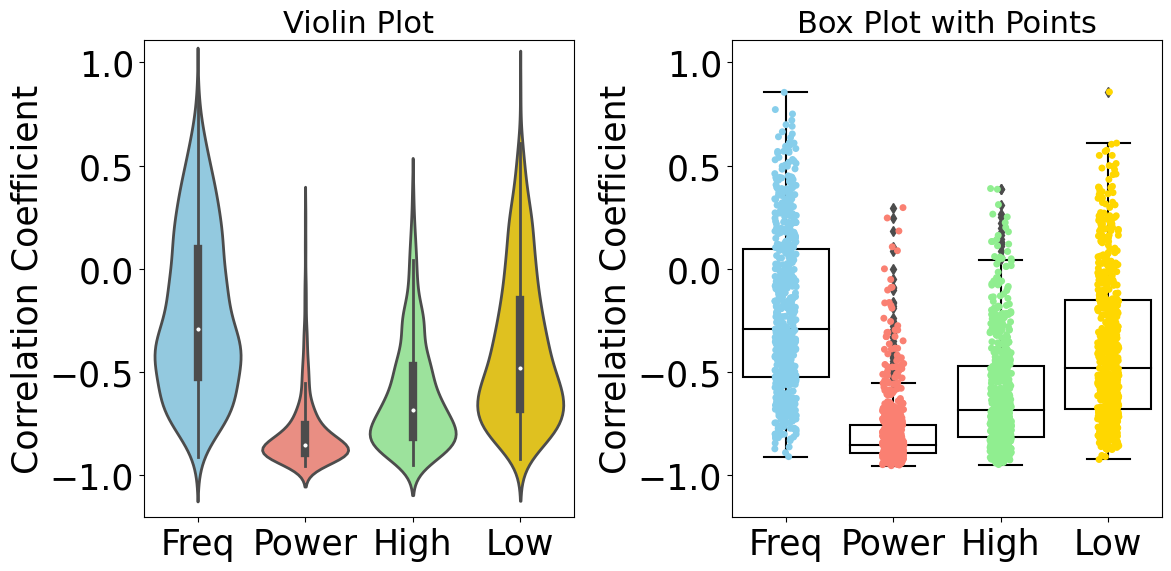

In [26]:
# Define colors for the categories
colors = {'Freq': 'skyblue', 'Power': 'salmon', 'High': 'lightgreen', 'Low': 'gold'}

# Calculate y-axis limits
y_min = df_violin['Correlation_Coefficient'].min() - 0.25
y_max = df_violin['Correlation_Coefficient'].max() + 0.25

plt.figure(figsize=(12, 6))

# -------------------------------
# Violin plot
# -------------------------------
plt.subplot(1, 2, 1)
sns.violinplot(
    x='Subject', y='Correlation_Coefficient',
    data=df_violin,
    palette=colors, inner='box', linewidth=2,  scale='width'  
)
plt.title('Violin Plot', fontsize=22)
plt.ylabel('Correlation Coefficient', fontsize=25)
plt.xlabel('')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(y_min, y_max)

# -------------------------------
# Box plot + strip points
# -------------------------------
plt.subplot(1, 2, 2)
sns.boxplot(
    x='Subject', y='Correlation_Coefficient',
    data=df_violin,
    palette=colors,
    boxprops={'facecolor': 'none', 'edgecolor': 'black'},  # unfilled boxes
    whiskerprops={'color': 'black'},
    capprops={'color': 'black'},
    medianprops={'color': 'black'}
)
sns.stripplot(
    x='Subject', y='Correlation_Coefficient',
    data=df_violin,
    palette=colors
)
plt.title('Box Plot with Points', fontsize=22)
plt.ylabel('Correlation Coefficient', fontsize=25)
plt.xlabel('')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()


C:\Users\sorenza_bastiaens\AppData\Local\Temp\ipykernel_1952\436323088.py:62: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
C:\Users\sorenza_bastiaens\Anaconda3\envs\mne_bids\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sorenza_bastiaens\Anaconda3\envs\mne_bids\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sorenza_bastiaens\Anaconda3\envs\mne_bids\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` 

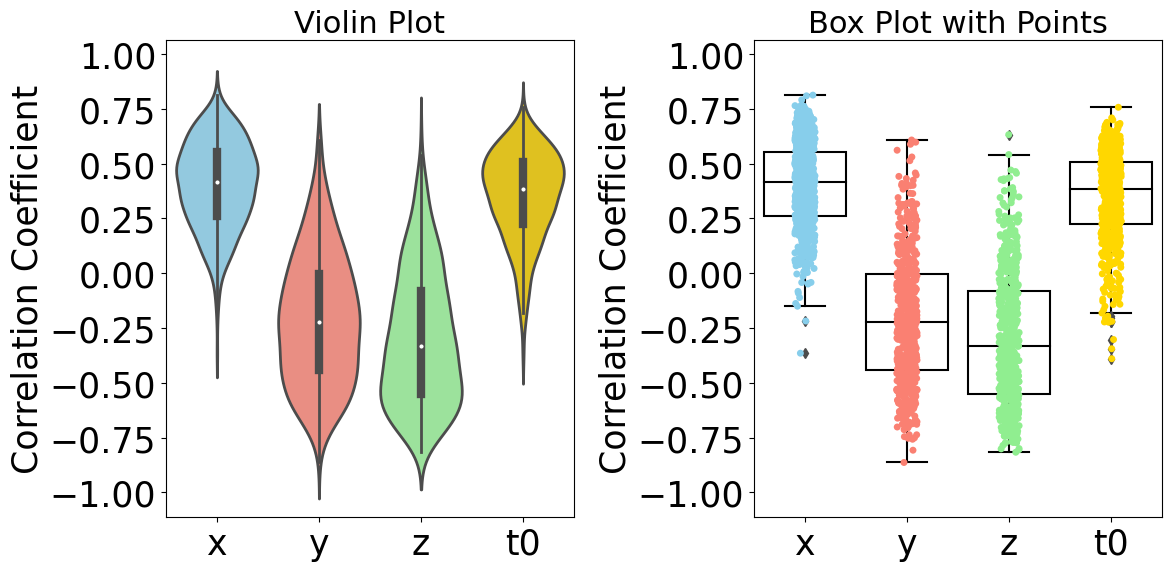

In [29]:
new_x = np.reshape(df['x'], (607,200))
new_y = np.reshape(df['y'], (607,200))
new_z = np.reshape(df['z'], (607,200))
new_t0 = np.reshape(df['t0'], (607,200))

# Calculate correlation coefficients for each subject
correlation_coefficients_x = [np.corrcoef(y_avg_coord, x)[0, 1] for x in new_x]
correlation_coefficients_y = [np.corrcoef(y_avg_coord, y)[0, 1] for y in new_y]
correlation_coefficients_z = [np.corrcoef(y_avg_coord, z)[0, 1] for z in new_z]
correlation_coefficients_t0 = [np.corrcoef(y_avg_coord, t0)[0, 1] for t0 in new_t0]

# Creating a DataFrame
df_violin = pd.DataFrame({
    'Subject': ['x'] * len(correlation_coefficients_x) +
               ['y'] * len(correlation_coefficients_y) +
               ['z'] * len(correlation_coefficients_z) +
               ['t0'] * len(correlation_coefficients_t0),
    'Correlation_Coefficient': correlation_coefficients_x +
                               correlation_coefficients_y +
                               correlation_coefficients_z +
                               correlation_coefficients_t0
})

# Define colors for the categories
colors = {'x': 'skyblue', 'y': 'salmon', 'z': 'lightgreen', 't0': 'gold'}

# Calculate y-axis limits
y_min = df_violin['Correlation_Coefficient'].min() - 0.25
y_max = df_violin['Correlation_Coefficient'].max() + 0.25

plt.figure(figsize=(12, 6))

# -------------------------------
# Violin plot
# -------------------------------
plt.subplot(1, 2, 1)
sns.violinplot(
    x='Subject', y='Correlation_Coefficient',
    data=df_violin,
    palette=colors, inner='box', linewidth=2,  scale='width'  
)
plt.title('Violin Plot', fontsize=22)
plt.ylabel('Correlation Coefficient', fontsize=25)
plt.xlabel('')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(y_min, y_max)

# -------------------------------
# Box plot + strip points
# -------------------------------
plt.subplot(1, 2, 2)
sns.boxplot(
    x='Subject', y='Correlation_Coefficient',
    data=df_violin,
    palette=colors,
    boxprops={'facecolor': 'none', 'edgecolor': 'black'},  # unfilled boxes
    whiskerprops={'color': 'black'},
    capprops={'color': 'black'},
    medianprops={'color': 'black'}
)
sns.stripplot(
    x='Subject', y='Correlation_Coefficient',
    data=df_violin,
    palette=colors
)
plt.title('Box Plot with Points', fontsize=22)
plt.ylabel('Correlation Coefficient', fontsize=25)
plt.xlabel('')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()


[fetch_surf_fsaverage] Dataset found in C:\Users\sorenza_bastiaens\nilearn_data\fsaverage

C:\Users\sorenza_bastiaens\Anaconda3\envs\mne_bids\Lib\site-packages\nibabel\freesurfer\io.py:61: UserWarning: Unknown extension code.
  warnings.warn('Unknown extension code.')
C:\Users\sorenza_bastiaens\Anaconda3\envs\mne_bids\Lib\site-packages\nibabel\freesurfer\io.py:187: UserWarning: No volume information contained in the file
  warnings.warn('No volume information contained in the file')
C:\Users\sorenza_bastiaens\AppData\Local\Temp\ipykernel_1952\504105620.py:54: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(fsaverage['white_right'], bg_map = lhc,bg_on_data=True, stat_map=vertex_values[stat],


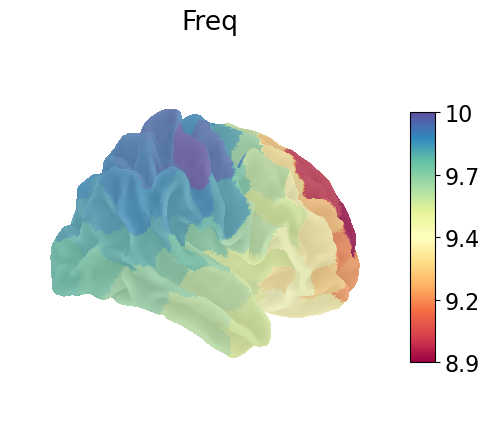

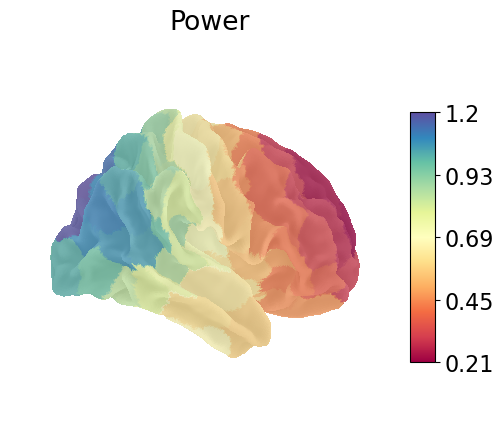

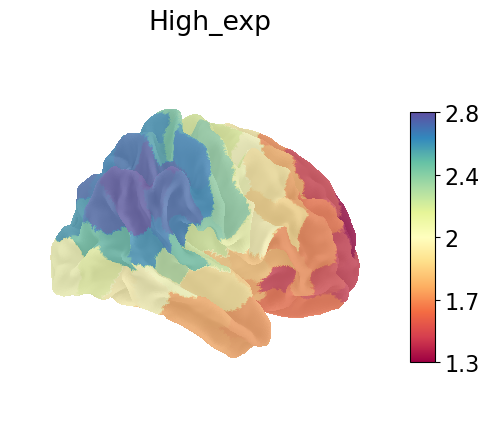

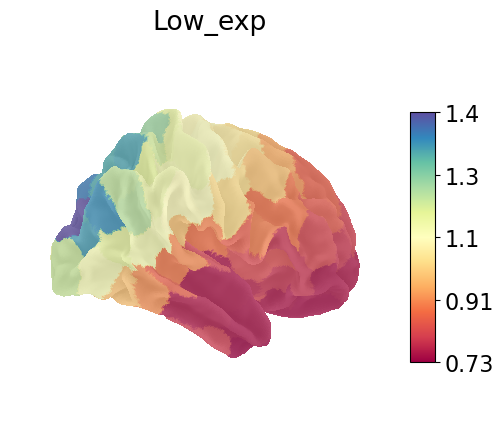

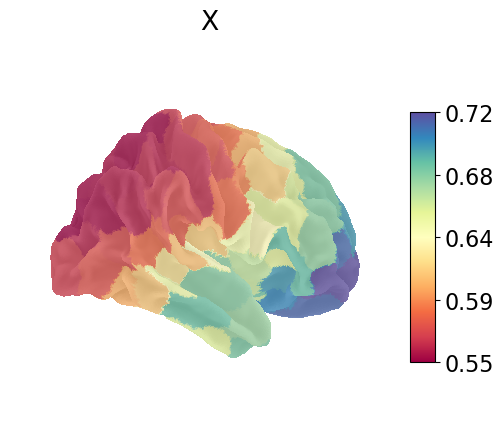

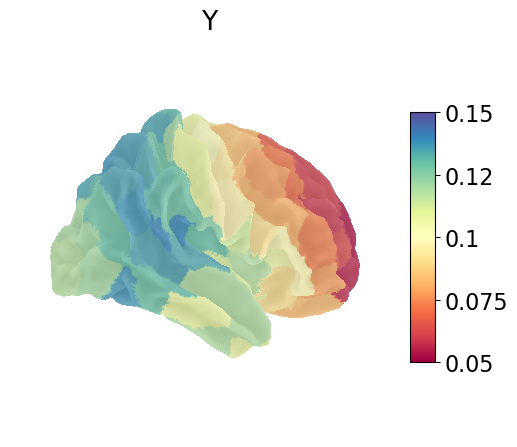

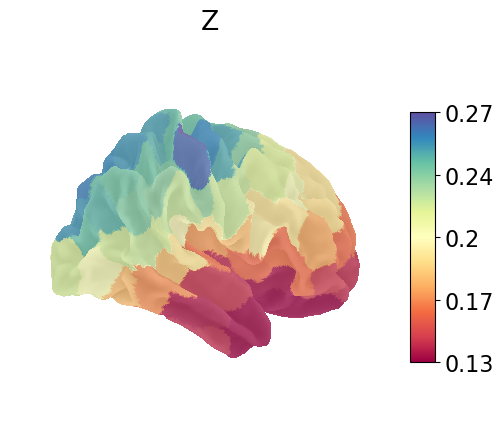

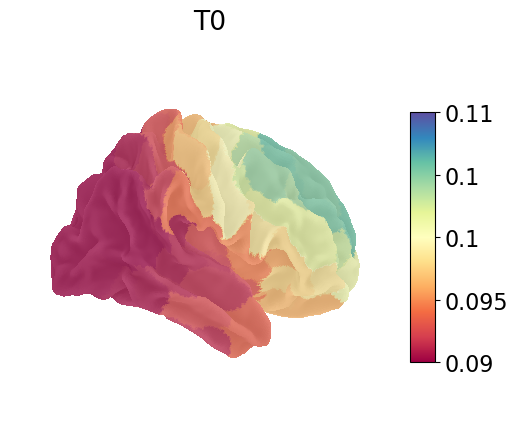

In [4]:

# Plotting average spatial gradient (across all age groups) on brain surface for visualization
fsaverage_directory = '/Users/sorenza_bastiaens/Documents/Project_2/freesurfer_subjects/fsaverage_small/'
fsaverage = {
    'white_left': fsaverage_directory + 'surf/lh.white',
    'white_right': fsaverage_directory + 'surf/rh.white',
}

# Get background mesh
fs7 = fetch_surf_fsaverage(mesh='fsaverage')
lhc = surface.load_surf_data(fs7['curv_right'])

# Define ROI ID and remove nan values
df['roi_id'] = df.index % 200

# List feature and models to plot on brain
list_of_components = ['freq','power','high_exp','low_exp', 'x','y','z','t0']

# Get average for each ROI 
average = df.groupby('roi_id')[list_of_components].mean()

# Initialize the matrix with zeros
network_matrix = np.zeros(len(label_names), dtype=int)

# Assign values to the matrix based on label names and network_indices
for i, label_name in enumerate(label_names):
    for network, index in network_color_indices.items():
        if network in label_name:
            network_matrix[i] = index
            break

vertex_values = {}
num_vertices = 163842

roi_to_vertices = [label.vertices for label in labels[:-2]]
roi_values_stat = network_matrix

# Map the values from each ROI to the respective vertices
for stat in list_of_components:
    average_stat_all = average[stat]
    roi_values_stat = average_stat_all

    # Initialize vertex_values with NaN
    vertex_values[stat] = np.full(num_vertices, np.nan)

    # Map the values from each ROI to the respective vertices
    for roi_idx, vertices in enumerate(roi_to_vertices):
        vertex_values[stat][vertices] = roi_values_stat[roi_idx]
        
    title = stat.capitalize()
    vmin = round(np.nanmin(vertex_values[stat]), 2)
    vmax = round(np.nanmax(vertex_values[stat]), 2)
    
    # Note: For modelling parameter, color was changed in paper on figure, using cmap='PiYG' instead of 'Spectral'
    plotting.plot_surf_stat_map(fsaverage['white_right'], bg_map = lhc,bg_on_data=True, stat_map=vertex_values[stat],
                                hemi='right', view='lateral', vmin=vmin, vmax=vmax,
                                cmap='Spectral', colorbar=True, title=title)
    plt.show()